**Import modules and set paths.**

In [1]:
import os
import sys
## make paths above 'notebooks/' visible for local imports.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd 
from scipy.sparse import coo_matrix
# from scipy.linalg import lstsq
print(f"using numpy v{np.__version__}.")
print(f"using pandas v{pd.__version__}.")

import matplotlib
import matplotlib.pyplot as plt

from lininvbox.lininvbox.equation import Term
# from lininvbox.lininvbox.basetypes import DesignMatrix, DataArray 
from lininvbox.lininvbox.constructors import *
from lininvbox.lininvbox.operations import *
from lininvbox.lininvbox.inversion import Inversion
from lininvbox.lininvbox.constraints import *
from lininvbox.lininvbox.regularisation import *
from magscales.magscales import Richter1958
from plotconf import matsettings

using numpy v1.19.4.
using pandas v1.1.5.


/opt/anaconda3/envs/YPML/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## Yellowstone National Park $M_L$ Non-Paramatric Inversion
### A notebook to perform a non-parametric inversion to recover $M_L$, distance and station corrections using earthquakes from Yellowstone Nation Park.



In [2]:
PDIR = ".."
for_inv = pd.read_csv(f"{PDIR}/catalogs/amplitudes/yellowstone.amps.clean.geobalanced.csv")
sims = pd.read_csv(f"{PDIR}/miscmeta/simulations/data/sim_out.csv")

In [3]:
interp_nodes = np.array([1, 10, 30, 50, 100, 180])
inc = np.geomspace(4, 180, 20)
dr = 5
inc = np.arange(20, 180+dr, dr)
interp_nodes = np.round(np.append([6,9,12,15,18,21], inc[inc>=25]), 1)
# interp_nodes=inc
interp_values = np.sort(for_inv.Rhyp.values)



In [4]:
def vis_inv_output(inv):

    terms = inv.m.term_map.values.keys()
    X, Y = [],[]
    for term in terms:
        tmp = inv.m.term_map.get_term(term)
        if term == "MLi":
            X.append(tmp['unique_indices'])
        else:
            X.append(tmp['unique_labels'])
        Y.append(tmp['model_values'])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, y, x, term in zip(axes, Y, X, terms):
        ax.plot(x, y, 'ks', mfc='none')
        ax.set_ylabel(term)
        if term == "Sj":
            ax.tick_params(axis='x', labelrotation = 90)
            
    return fig, axes

def vis_matrices(mats, kind='spy', **kwargs):

    fs = (4.5*2, 15)
    
    if type(mats) is list:
        assert type(mats[0]) is coo_matrix or type(mats[0]) is np.ndarray,\
        f"Matrices in list must be coo_matrix or np.ndarray not {type(mats[0])}."

        fig, axes = plt.subplots(1, num_mats, figsize=fs)
    else:
        fig, axes = plt.subplots(1, 1, figsize=fs)
        axes = [axes,]
        mats = [mats,]

    for mat, ax in zip(mats, axes):

        # spy plot
        if kind == 'spy':
            ax.spy(mat, aspect='auto', **kwargs)
        # matshot
        if kind == 'matshow':
            a = ax.matshow(mat.toarray(), aspect='auto', **kwargs)
            fig.colorbar(a)

    fig.tight_layout()
    
    return fig, axes

def roughness(m, term:str):
    inds = m.term_map.values[term]['model_indices']
    return np.linalg.norm(np.diff(m.array.toarray().flatten()[inds], 2))

def MSE(fd, d):
    r = d.array.toarray() - fd.array.toarray()
    return np.mean(r**2) 

In [5]:
stas = for_inv[["Net", "Sta"]].agg('.'.join, axis=1).values
evs = for_inv['Evid'].apply(str).values

In [6]:
logA0np = Term("logA0n", "LINEAR INTERPOLATION", for_inv.Rhyp.values, unique_labels=interp_nodes)
MLp = Term("MLi", "CONSTANT", evs)
Sjp = Term("Sj", "CONSTANT", stas, sign=-1)

In [7]:
logA0n = LinInterpCoeffs(logA0np) 
MLi = ConstantCoeffs(MLp)
Sj = ConstantCoeffs(Sjp)
G = logA0n + MLi + Sj
d = DataArray(for_inv['halfAmpH'].apply(np.log10))

In [8]:
inv = Inversion("YPML")

In [9]:
inv.invert(G, d)

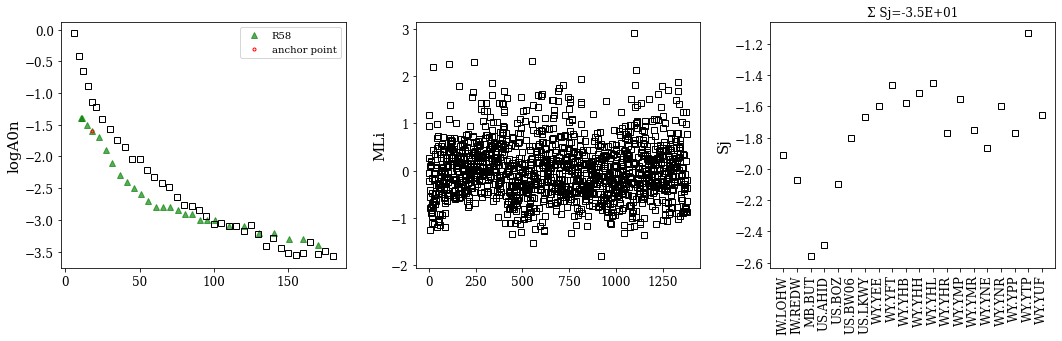

In [10]:
r = Richter1958()
r.epi_to_hypo(av_dep=10.5)
fig, axes = vis_inv_output(inv)
axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
axes[0].legend()
axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
fig.tight_layout()
# axes[0].set_xscale("log")

In [11]:
np.mean((inv.forward(G, inv.m).array.toarray().flatten() - d.array.toarray().flatten())**2)

0.037669152772015144

In [12]:
# fig, axes = vis_matrices(G.matrix, kind='matshow', cmap="Greys")
# axes[0].set_xticklabels(np.append(0, np.round(interp_nodes, 0)))
inv.m.matrix.shape


(1439, 1)

In [13]:
mwcat = pd.read_csv("../catalogs/events/MTCAT.csv")
mwcat["Evid"] = mwcat["Evid"].astype(str)
MLcons = dict(mwcat[["Evid", "MwPref"]].values)


In [14]:

cons = OrderedDict(#logA0n={18:-1.6}, 
                   Sj={"SUM":0},)
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
#                    MLi=MLcons)


In [15]:
C = Constraints(G.term_map, constraints=cons)

In [16]:
inv = Inversion("YPML")
inv.invert(G, d, constraints=C)

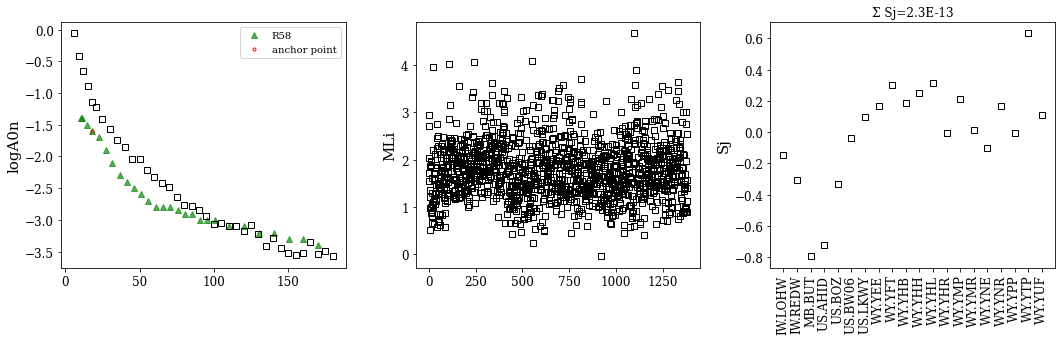

In [17]:
r = Richter1958()
r.epi_to_hypo(av_dep=10.5)
fig, axes = vis_inv_output(inv)
axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
axes[0].legend()
axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
fig.tight_layout()

In [102]:
Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=5.14)))
inv = Inversion("YPML")
inv.invert(G, d, constraints=C, regularisation=Gamma)

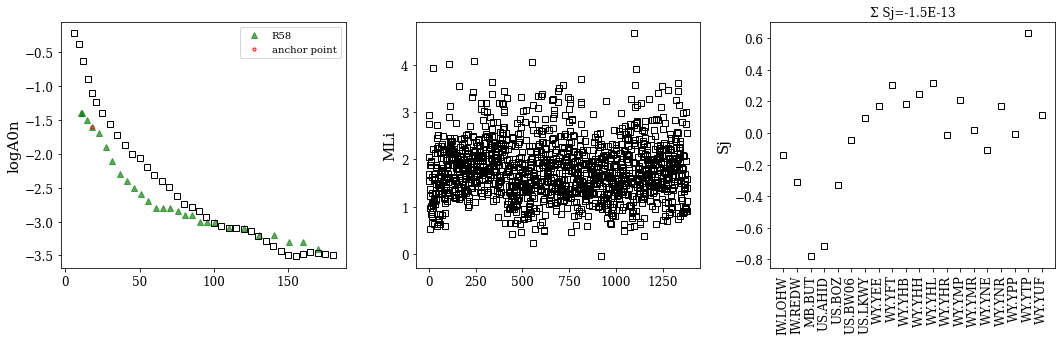

In [103]:
r = Richter1958()
r.epi_to_hypo(av_dep=10.5)
fig, axes = vis_inv_output(inv)
axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
axes[0].legend()
axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
fig.tight_layout()

In [20]:
# Sjout = G.term_map.get_term("Sj")
# scors = {key:Sjout[key] for key in ("unique_labels","model_values")}
# pd.DataFrame(scors).rename(dict(unique_labels="Station", model_values="Sj"))

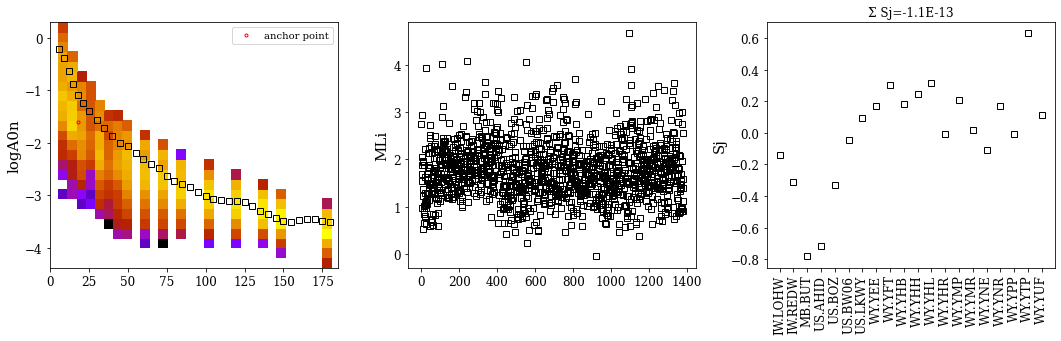

In [36]:
r = Richter1958()
r.epi_to_hypo(av_dep=10.5)
fig, axes = vis_inv_output(inv)
axes[0].hist2d(sims.rhyp, sims.A-0.8, bins=(30,25), cmap="gnuplot", norm=matplotlib.cm.colors.LogNorm(),)

# axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
axes[0].set_xlim([0, 185])
axes[0].legend()
axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
fig.tight_layout()

## Smoothing parameter ($\alpha$) penalty tests

### Roughness vs MSE
In the first set of tests we show the roughness ($||\dfrac{\mathrm{d^2}logA_{0}(R)}{\mathrm{d}R^2}||^2$) by the mean error  of the resdiuals between predicted and recorded data (MSE). 

In [104]:
alphas = np.geomspace(1E-1, 20, 40)
rough = np.zeros(len(alphas))
mse = np.zeros(len(alphas))

for i in range(len(alphas)):
    Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alphas[i])))
    inv = Inversion("YPML")
    m = inv.invert(G, d, regularisation=Gamma, inplace=False)
    fd = inv.forward(G, m)    
    mse[i] = MSE(fd, d)
    rough[i] = roughness(m, "logA0n")
# point of maximum curvature on L-curve is the optimal value for alpha   
pt = np.abs(np.diff(np.log10(rough), 2)).argmin() 

We obtain an "L-curve" and choose the value for alpha at the point of maximum curvature (2nd derivative is minimum).

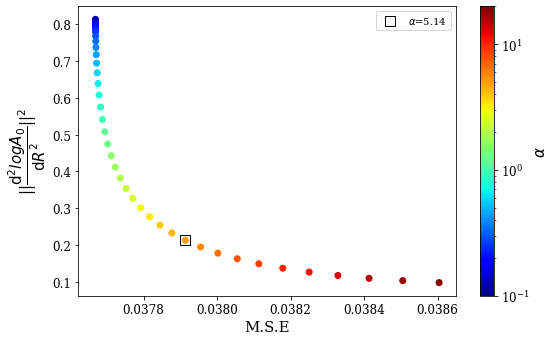

In [105]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
out = ax.scatter(mse, rough, c=alphas, cmap="jet", norm=matplotlib.cm.colors.LogNorm()) 
ax.plot(mse[pt], rough[pt], 'ks', ms=10, mfc='none', label=r"$\alpha$={:.2f}".format(alphas[pt]))
ax.set_xlabel("M.S.E")
ax.set_ylabel(r"$||\dfrac{\mathrm{d^2}logA_{0}}{\mathrm{d}R^2}||^2$") 
ax.legend()
fig.tight_layout()
fig.colorbar(out, label=r"$\alpha$")